In [74]:
from gluonts.dataset.util import to_pandas
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx import Trainer

import pickle
import numpy as np

In [75]:
dataset = get_dataset("airpassengers")

In [76]:
deepar = DeepAREstimator(prediction_length=12, freq="M", trainer=Trainer(epochs=5))
model = deepar.train(dataset.train)

100%|█████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.55it/s, epoch=5/5, avg_epoch_loss=3.86]


In [77]:
with open('gluonts_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [78]:
# with open('gluonts_model', 'rb') as f:
#     model = pickle.load(f)

<AxesSubplot:>

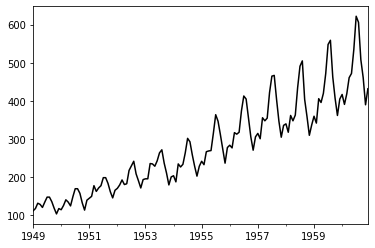

In [79]:
# Make predictions
true_values = to_pandas(list(dataset.test)[0])
true_values.to_timestamp().plot(color="k")

In [80]:
true_values[:-36]

1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1957-08    467.0
1957-09    404.0
1957-10    347.0
1957-11    305.0
1957-12    336.0
Freq: M, Length: 108, dtype: float32

In [81]:
prediction_input = PandasDataset([true_values[:-36], true_values[:-24], true_values[:-12]])
predictions = model.predict(prediction_input)

In [82]:
predictions

<generator object GluonPredictor.predict at 0x7fd23822e570>

In [83]:
len(prediction_input.dataframes)

3

In [84]:
prediction_input.dataframes[0]

,target
1949-01,112.0
1949-02,118.0
1949-03,132.0
1949-04,129.0
1949-05,121.0
...,...
1957-08,467.0
1957-09,404.0
1957-10,347.0
1957-11,305.0


In [87]:
# for color, prediction in zip(["green", "blue", "purple"], predictions):
#     # prediction.samples
#     prediction.plot(color=f"tab:{color}")

In [88]:
prediction_samples_list = [prediction.samples for prediction in predictions]
prediction_samples = np.rollaxis(np.dstack(prediction_samples_list), -1)

In [89]:
newarray[0, :, :].shape

(100, 12)

In [36]:
prediction_samples[1]

array([[341.9212 , 374.49957, 395.2998 , ..., 396.2906 , 371.84192,
        381.9706 ],
       [383.01718, 380.51553, 396.40707, ..., 354.29514, 352.00375,
        409.9256 ],
       [368.99426, 443.0466 , 397.78403, ..., 377.17056, 366.66745,
        399.01294],
       ...,
       [412.1965 , 370.36514, 405.70047, ..., 369.34402, 318.4941 ,
        421.8488 ],
       [371.31815, 361.28   , 406.51138, ..., 370.12625, 347.8882 ,
        386.65903],
       [378.50986, 389.12473, 408.1138 , ..., 343.81262, 349.35596,
        406.6107 ]], dtype=float32)

In [29]:
prediction

gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=numpy.array([[411.3222961425781, 404.1672668457031, 460.04461669921875, 424.221923828125, 486.6156921386719, 538.8576049804688, 606.4608154296875, 666.0499267578125, 530.1238403320312, 439.6001892089844, 393.88507080078125, 473.4535217285156], [408.7738342285156, 438.00799560546875, 447.94482421875, 420.2658996582031, 471.44720458984375, 585.0565185546875, 651.6948852539062, 647.2353515625, 519.7125244140625, 413.5704650878906, 370.357421875, 441.3489685058594], [469.58123779296875, 434.600341796875, 411.4370422363281, 456.1145324707031, 433.3255615234375, 575.9312133789062, 639.3767700195312, 637.4837036132812, 493.2800598144531, 385.65850830078125, 331.6307067871094, 452.4742736816406], [408.93157958984375, 449.2195739746094, 473.21392822265625, 400.7181091308594, 467.2835388183594, 533.00048828125, 643.3807983398438, 629.7195434570312, 536.4747924804688, 423.6677551269531, 386.6248474121094, 441.4943542480469], [